In [1]:
import os
import glob
from pyspark.sql import SparkSession

# Caminho da pasta de saída
output_folder = "../Scripts/output"

# Obter lista de arquivos CSV de blocos
block_files = glob.glob(os.path.join(output_folder, "block", "*.csv"))

# Obter lista de arquivos CSV de swaps
swap_files = glob.glob(os.path.join(output_folder, "swap", "*.csv"))

# Obter lista de arquivos CSV de transações
transaction_files = glob.glob(os.path.join(output_folder, "transaction", "*.csv"))

In [2]:
# Criar sessão Spark
spark = SparkSession.builder \
    .appName("Análise de Transações Ethereum") \
    .getOrCreate()

In [3]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_block_df = None

# Ler e unir os arquivos CSV de blocos
for file in block_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    if combined_block_df is None:
        combined_block_df = df
    else:
        combined_block_df = combined_block_df.unionAll(df)

In [4]:
combined_block_df = combined_block_df.drop("Gas_Limit")
combined_block_df = combined_block_df.drop("Gas_Used")
combined_block_df = combined_block_df.drop("Timestamp_Block")

In [5]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_swap_df = None

# Ler e unir os arquivos CSV de blocos
for file in swap_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    if combined_swap_df is None:
        combined_swap_df = df
    else:
        combined_swap_df = combined_swap_df.unionAll(df)

In [6]:
combined_swap_df = combined_swap_df.drop("Block_ID")

In [7]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_transaction_df = None

# Ler e unir os arquivos CSV de blocos
for file in transaction_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    if combined_transaction_df is None:
        combined_transaction_df = df
    else:
        combined_transaction_df = combined_transaction_df.unionAll(df)

In [8]:
combined_swap_df_cleaned = combined_swap_df.dropna(subset=['From_Token_Symbol', 'To_Token_Symbol', 'From_Token_Holders_Count', 'To_Token_Holders_Count', 'From_Token_Price', 'To_Token_Price'])

from pyspark.sql.functions import when, col

combined_swap_df_cleaned = combined_swap_df_cleaned.withColumn("From_Token_Price", when(col("From_Token_Price") == 0, float('nan')).otherwise(col("From_Token_Price")))
combined_swap_df_cleaned = combined_swap_df_cleaned.withColumn("To_Token_Price", when(col("To_Token_Price") == 0, float('nan')).otherwise(col("To_Token_Price")))

In [9]:
df_combined = combined_block_df.join(combined_transaction_df, "Block_ID").join(combined_swap_df_cleaned, "Hash_Transaction")

In [10]:
df_combined_pandas = df_combined.toPandas()
df_combined_pandas.to_csv('combined_df.csv', index=False)

In [11]:
from pyspark.sql.functions import count

# Agrupar por símbolo da moeda e contar o número de transações
transaction_count_df = df_combined.groupBy("From_Token_Symbol").agg(count("Hash_Transaction").alias("Transaction_Count"))

# Ordenar em ordem decrescente pelo número de transações
top_10_coins_df = transaction_count_df.orderBy("Transaction_Count", ascending=False).limit(10)

In [12]:
top_10_coins_df.show()

+-----------------+-----------------+
|From_Token_Symbol|Transaction_Count|
+-----------------+-----------------+
|             WETH|               86|
|           RETIRE|               31|
|          DOGE2.0|               31|
|              FAI|                6|
|        GODCANDLE|                3|
|         FROKI2.0|                2|
|              SOS|                2|
|             BOBO|                1|
|           Patpep|                1|
|          THREADS|                1|
+-----------------+-----------------+



In [13]:
top_10_coins = top_10_coins_df.select("From_Token_Symbol").rdd.flatMap(lambda x: x).collect()

In [14]:
filtered_df = df_combined.filter(df_combined.From_Token_Symbol.isin(top_10_coins))

In [15]:
sorted_df = filtered_df.orderBy("Timestamp_Transaction")

In [20]:
from pyspark.sql.functions import lag, col

# Definir a janela de partição para cada símbolo de moeda
window = Window.partitionBy("From_Token_Symbol").orderBy("Timestamp_Transaction")

# Calcular a diferença de holders em relação à linha anterior
diff_holders = col("From_Token_Holders_Count") - lag(col("From_Token_Holders_Count")).over(window)

# Calcular a taxa de crescimento dividindo a diferença pelo número de holders anterior
growth_rate_df = sorted_df.withColumn("Growth_Rate", diff_holders / lag(col("From_Token_Holders_Count")).over(window))

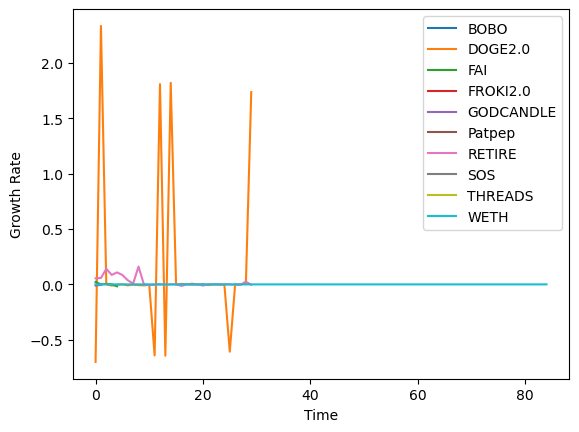

In [22]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_list

# Coletar os dados do DataFrame resultante em uma lista no driver
growth_rate_data = growth_rate_df.select("From_Token_Symbol", "Growth_Rate").groupBy("From_Token_Symbol").agg(collect_list("Growth_Rate").alias("Growth_Rates")).collect()

# Plotar o gráfico de taxa de crescimento para cada moeda
for row in growth_rate_data:
    symbol = row.From_Token_Symbol
    growth_rates = row.Growth_Rates
    plt.plot(growth_rates, label=symbol)

plt.xlabel("Time")
plt.ylabel("Growth Rate")
plt.legend()
plt.show()

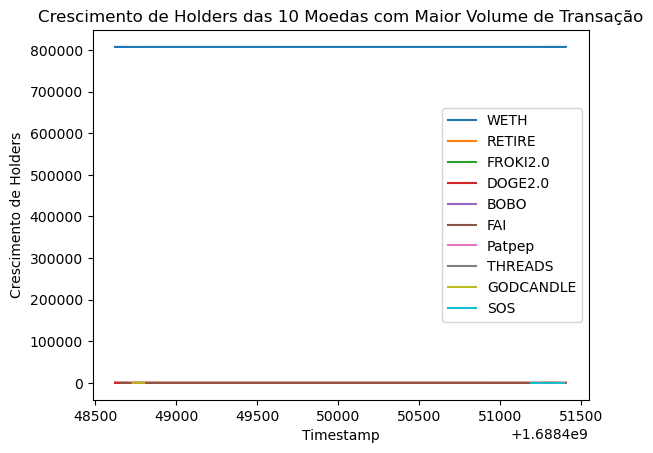

In [25]:
import matplotlib.pyplot as plt

# Filtrar as 10 moedas com maior volume de transação
top_coins = growth_rate_df.groupBy("From_Token_Symbol").count().orderBy("count", ascending=False).limit(10)
filtered_growth_rate_df = growth_rate_df.join(top_coins, "From_Token_Symbol")

# Coletar os dados do DataFrame filtrado para cada moeda separadamente
coin_data = {}
for coin in filtered_growth_rate_df.select("From_Token_Symbol").distinct().collect():
    coin_symbol = coin["From_Token_Symbol"]
    time = filtered_growth_rate_df.filter(filtered_growth_rate_df["From_Token_Symbol"] == coin_symbol).select("Timestamp_Transaction").toPandas()["Timestamp_Transaction"]
    growth = filtered_growth_rate_df.filter(filtered_growth_rate_df["From_Token_Symbol"] == coin_symbol).select("From_Token_Holders_Count").toPandas()["From_Token_Holders_Count"]
    coin_data[coin_symbol] = (time, growth)

# Plotar o gráfico separadamente para cada moeda
for coin_symbol, (time, growth) in coin_data.items():
    plt.plot(time, growth, label=coin_symbol)

plt.xlabel("Timestamp")
plt.ylabel("Crescimento de Holders")
plt.title("Crescimento de Holders das 10 Moedas com Maior Volume de Transação")
plt.legend()
plt.show()